# BERT Loris - CPE Lyon (05/04/2020)

# Initialization

In [1]:
import benchmark

noise_model_file = "noise_model.py"

%matplotlib inline

# T1 Benchmark

Import
Circuit
Noise model
Simulation
Fitting
Display

      | T1 exp (µs)
---------------------
  Q0  |   68.37
---------------------
  Q1  |   88.64
---------------------
  Q2  |   79.61
---------------------
  Q3  |   88.74
---------------------
  Q4  |   78.98
---------------------


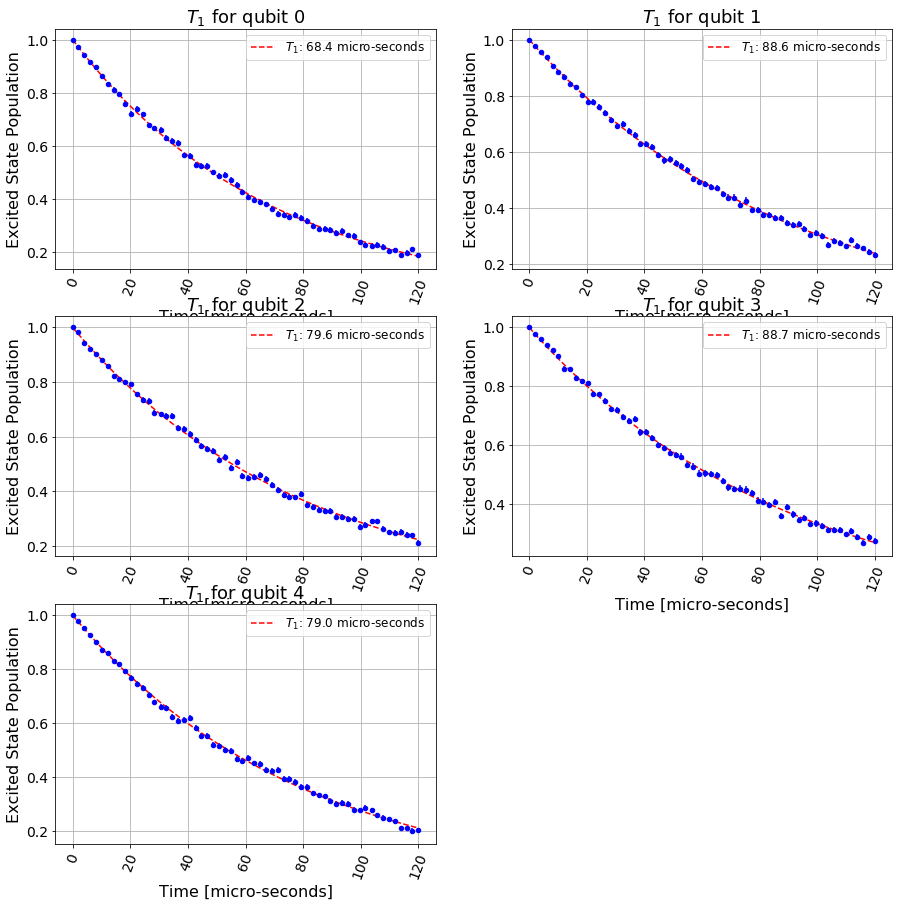


Running time: 149.23 s

{'Q0': 6.837234725692309e-05, 'Q1': 8.864452491347458e-05, 'Q2': 7.96090641644527e-05, 'Q3': 8.873627497110056e-05, 'Q4': 7.898440048163974e-05}


In [2]:
# Takes ~95s (1min 35s) on an i7-8700 (4.30 Ghz) processor for N=60

dict_coherence_times_T1 = benchmark.T1Benchmark(noise_model_file, 
                                                t=[70.5, 85.0, 80.0, 90.5, 77.5], 
                                                N=60, 
                                                display=True)

print(dict_coherence_times_T1)

# T2* Benchmark

Import
Circuit
Noise model
Simulation
Fitting
Display

      | T2* exp (µs)
---------------------
  Q0  |   71.91
---------------------
  Q1  |   86.26
---------------------
  Q2  |   80.69
---------------------
  Q3  |   91.27
---------------------
  Q4  |   76.7
---------------------


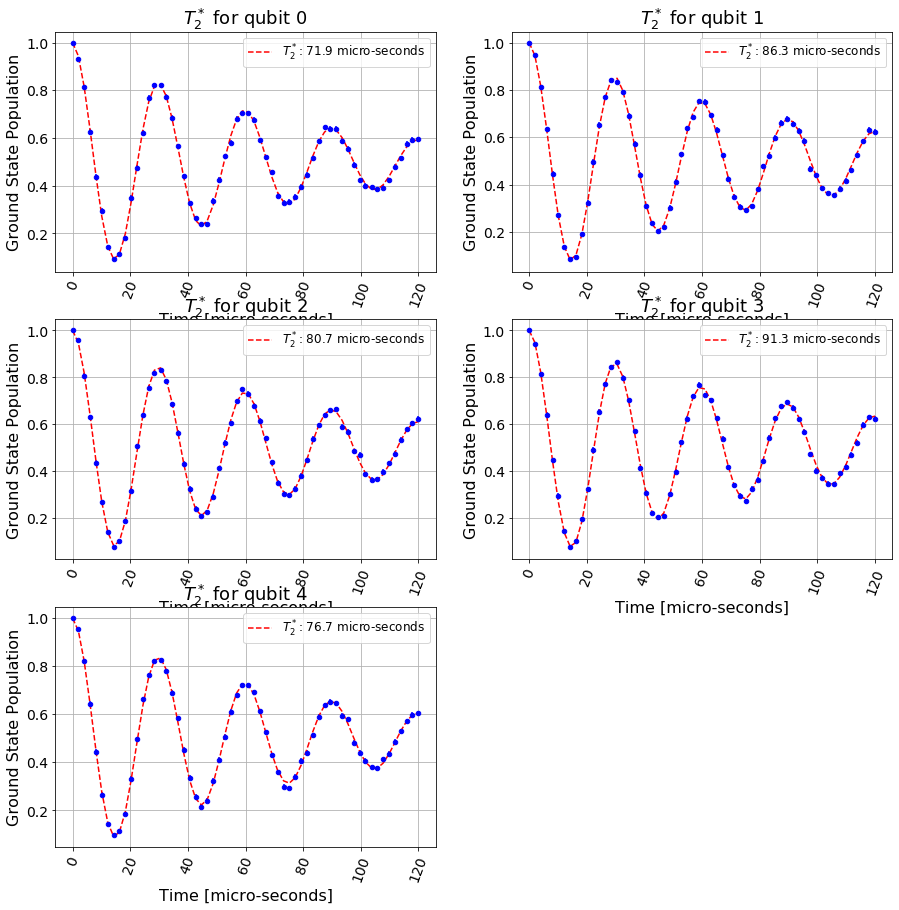


Running time: 93.6 s

{'Q0': 7.190756566444943e-05, 'Q1': 8.625888892159414e-05, 'Q2': 8.068847499417973e-05, 'Q3': 9.12724027296869e-05, 'Q4': 7.669886002401024e-05}


In [3]:
# Takes ~95s (1min 35s) on an i7-8700 (4.30 Ghz) processor for N=60

dict_coherence_times_T2 = benchmark.T2Benchmark(noise_model_file,
                                                t=[70.5, 85.0, 80.0, 90.5, 77.5],
                                                N=60,
                                                display=True)

print(dict_coherence_times_T2)

In [3]:
import time
import importlib

import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.ignis.characterization.coherence import t1_circuits, t2star_circuits, T1Fitter, T2StarFitter

In [7]:
num_of_gates = (np.linspace(0, 1200, 60)).astype(int)
qubits = list(range(5))


t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time=0.1, qubits=qubits, nosc=4)


from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel


def t1_noise_model(gate_time=0.1, t=[70.5, 85.0, 80.0, 90.5, 77.5]):
    """
    Return a NoiseModel object for T1.
    
    Parameters
        - gate_time: gate time (in microseconds) for a single-qubit gate
        - t: simulated times (in microseconds) for a set of five qubits 
    """
    
    t1_noise_model = NoiseModel()
    error = [0 for i in range(5)]
    
    for i in range(5):
        error[i] = thermal_relaxation_error(t[i], 2*t[i], gate_time)
        t1_noise_model.add_quantum_error(error[i], 'id', [i])
    
    return t1_noise_model




def t2_star_noise_model(gate_time=0.1, t=[70.5, 85.0, 80.0, 90.5, 77.5]):
    """
    Return a NoiseModel object for T2*.
    
    Parameters
        - gate_time: gate time (in microseconds) for a single-qubit gate
        - t: simulated times (in microseconds) for a set of five qubits 
    """

    t2_star_noise_model = NoiseModel()
    error = [0 for i in range(5)]
    
    for i in range(5):
        error[i] = thermal_relaxation_error(np.inf, t[i], gate_time, 0.5)
        t2_star_noise_model.add_quantum_error(error[i], 'id', [i])
    
    return t2_star_noise_model


# === Simulation ===
print("Simulation")

backend = qiskit.Aer.get_backend('qasm_simulator')

t2star_backend_result = qiskit.execute(t2star_circs, backend, 
                                           shots=1024,
                                           noise_model=t2_star_noise_model(), 
                                           optimization_level=0).result()


    # === Fitting ===
print("Fitting")

t2star_fit = T2StarFitter(t2star_backend_result, 
                              t2star_xdata, 
                              qubits,
                              fit_p0=     [ 0.5,  50,   osc_freq,      0,  0.5],
                              fit_bounds=([-0.5,   0,          0, -np.pi, -0.5],
                                          [ 1.5, 100, 2*osc_freq,  np.pi,  1.5]))

list_coherence_times = t2star_fit.time()

Simulation
Fitting


In [8]:
list_coherence_times

[70.8292437090688,
 86.10468304859366,
 78.92121885939697,
 93.07414493801302,
 77.14875164091535]

In [10]:
t2star_fit.params


{'0': [array([ 4.99039483e-01,  7.08292437e+01,  3.33619962e-02, -6.27396375e-03,
          5.00968731e-01]),
  array([ 4.99820335e-01,  8.61046830e+01,  3.33554945e-02, -1.61074863e-02,
          5.00245228e-01]),
  array([ 5.00052841e-01,  7.89212189e+01,  3.33578909e-02, -1.81057081e-02,
          5.00028781e-01]),
  array([4.98392594e-01, 9.30741449e+01, 3.32840411e-02, 1.72898971e-02,
         5.01685199e-01]),
  array([ 5.00320014e-01,  7.71487516e+01,  3.33612784e-02, -5.42547007e-03,
          4.99687527e-01])]}